In [ ]:
# IndicBERT requires the following versions
!pip install -q torch==1.4.0
!pip install -q transformers==2.8.0

In [ ]:
# importing libraries
import transformers
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import os

# set parameters
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# input text preprocessing
PRE_TRAINED_MODEL_NAME = 'ai4bharat/indic-bert'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'अरे बाबा! केशू जी।'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

In [ ]:
# loading data from the drive
df_train = pd.read_csv('/content/drive/MyDrive/datasets/train.tsv',sep='\t')
df_test = pd.read_csv('/content/drive/MyDrive/datasets/test.tsv',sep='\t')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Max token length:  33


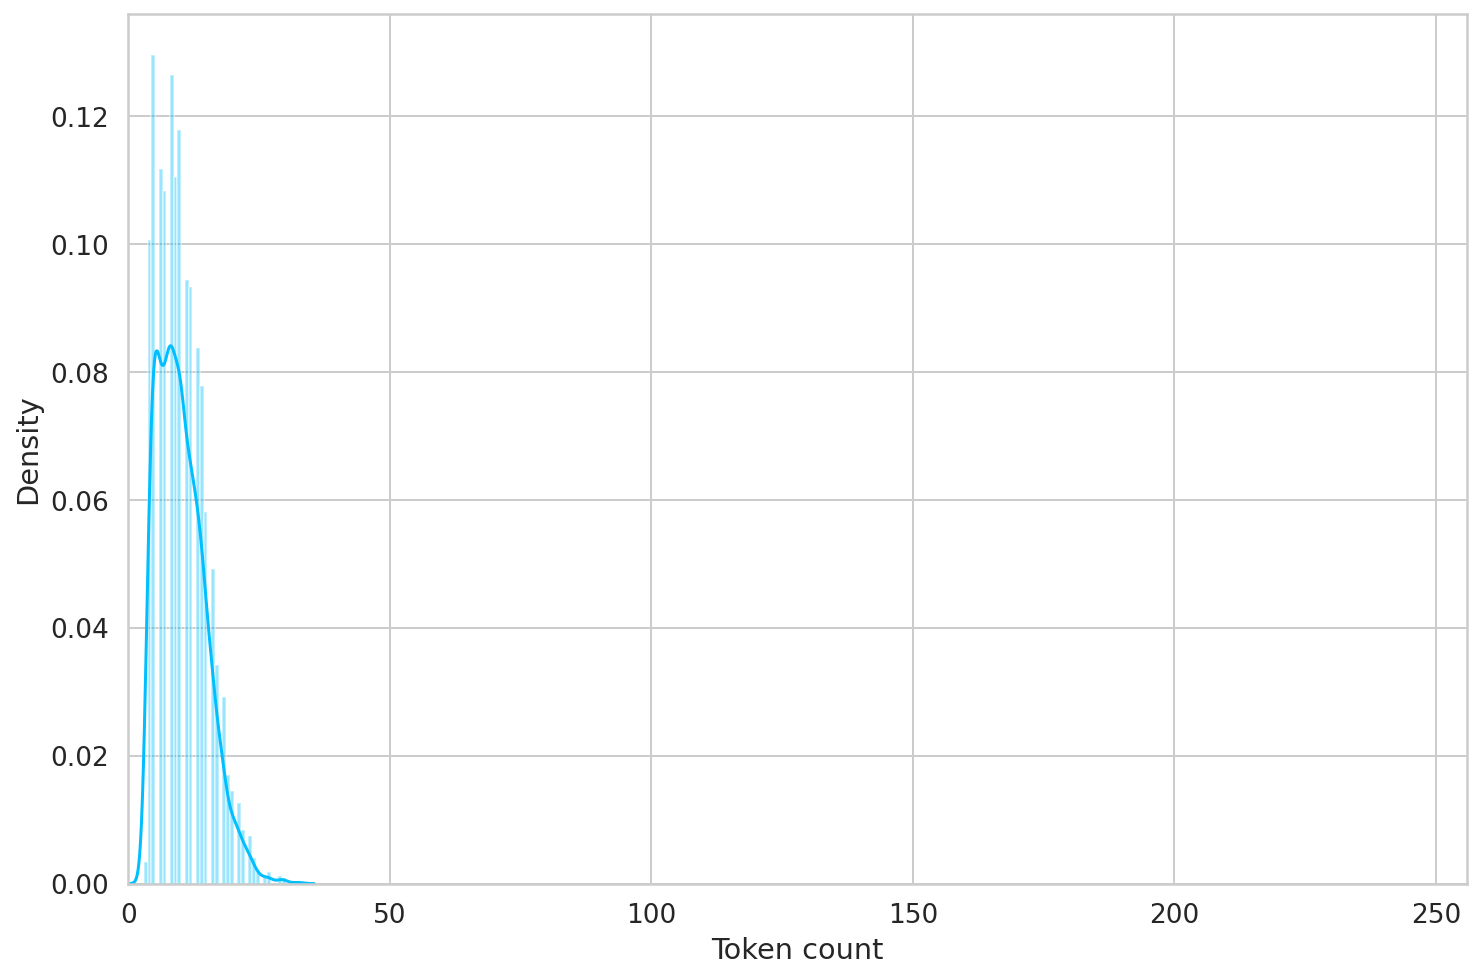

In [ ]:
#Choosing sequence lenght for training the IndicBERT model
token_lens = []
for txt in df_train.Utterance:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

# plotting the frequency(here percentage) of token lengths to better understand the distribution
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

# max token length
MAX_LEN = max(token_lens)
print("Max token length: ",MAX_LEN)

In [ ]:
# creating dataset
class M2H2_Text_Dataset(Dataset):
  def __init__(self, utterance, label, tokenizer, max_len):
    self.utterance = utterance
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.utterance)
  def __getitem__(self, item):
    utterance = str(self.utterance[item])
    label = self.label[item]
    encoding = self.tokenizer.encode_plus(
      utterance,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'utterance': utterance,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.long)
    }

In [ ]:
print('Number of utterances that are not humorous: ',sum(df_train['Label']==False),'/',len(df_train))
print('Number of utterances that are humorous: ',sum(df_train['Label']==True),'/',len(df_train))

Number of utterances that are not humorous:  3011 / 4549
Number of utterances that are humorous:  1538 / 4549


In [ ]:
''' Vanilla data split without class balancing'''
# train-test split
df_train, df_val = train_test_split(
  df_train,
  test_size=0.1,
  random_state=RANDOM_SEED
)

In [ ]:
# creating data loader
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = M2H2_Text_Dataset(
    utterance=df.Utterance.to_numpy(),
    label=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# load the pretrained Indic-BERT model
model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.indic_bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.indic_bert_model.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.indic_bert_model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.drop(pooled_output)
    output = pooled_output
    return self.out(output)

In [ ]:
model = SentimentClassifier(2) # as we have just two classes: humorous and not humorous 
model = model.to(device)

In [ ]:
# training
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["label"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["utterance"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
class_names = ['not humorous', 'humorous']
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
print(confusion_matrix(y_test, y_pred))

In [ ]:
print("Training data stats:")
print('Number of utterances that are not humorous: ',sum(df_train['Label']==False),'/',len(df_train))
print('Number of utterances that are humorous: ',sum(df_train['Label']==True),'/',len(df_train))
print('------')
print("Validation data stats:")
print('Number of utterances that are not humorous: ',sum(df_val['Label']==False),'/',len(df_val))
print('Number of utterances that are humorous: ',sum(df_val['Label']==True),'/',len(df_val))
print('------')
print("Test data stats:")
print('Number of utterances that are not humorous: ',sum(df_test['Label']==False),'/',len(df_test))
print('Number of utterances that are humorous: ',sum(df_test['Label']==True),'/',len(df_test))

---

# Using sentence-BERT for getting embeddings for sentences instead of individual tokens

Github Page: https://github.com/UKPLab/sentence-transformers <br />
vocab file: https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v2/blob/main/vocab.txt
(It has hindi letters) <br />
documentation for pretrained sentence-BERT models: https://www.sbert.net/docs/pretrained_models.html

In [ ]:
!pip install -U sentence-transformers -q

In [ ]:
import transformers
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

# input text preprocessing
PRE_TRAINED_MODEL_NAME = 'ai4bharat/indic-bert'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

In [ ]:
sentences = ['अरे बाबा! केशू जी।',
    'अरे बाबा! केशू जी। केशू जी। केशू जी।']
sentence_embeddings = model.encode(sentences)

In [ ]:
sentence_embeddings.shape

(2, 512)

In [ ]:
sample_txt = 'अरे बाबा! केशू जी।'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: अरे बाबा! केशू जी।
   Tokens: ['▁अर', '▁बब', '!', '▁कश', '▁ज', '।']
Token IDs: [13734, 41231, 477, 128648, 4765, 15]


In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv('train.tsv',sep='\t')
test_df = pd.read_csv('test.tsv',sep='\t')

In [ ]:
sentences_train = list(train_df['Utterance'])
sentence_embeddings_train = model.encode(sentences_train) # took ~ 6mins on CPU

In [ ]:
sentences_test = list(test_df['Utterance'])
sentence_embeddings_test = model.encode(sentences_test) # took ~ 2mins on CPU

In [ ]:
sentence_embeddings_test.shape

(1636, 512)

In [ ]:
#Human readable data
np.savetxt('train_text_utterance_embeddings.txt', sentence_embeddings_train)
# to load:>> x = np.loadtxt('train_text_utterance_embeddings.txt')
np.savetxt('test_text_utterance_embeddings.txt', sentence_embeddings_test)

In [ ]:
cp test_text_utterance_embeddings.txt /content/drive/MyDrive/datasets/

---

# Getting embeddings from fastText

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.bin.gz 

--2021-10-29 11:04:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4371554972 (4.1G) [application/octet-stream]
Saving to: ‘cc.hi.300.bin.gz’

cc.hi.300.bin.gz    100%[===================>]   4.07G  20.3MB/s    in 3m 26s  

2021-10-29 11:08:12 (20.2 MB/s) - ‘cc.hi.300.bin.gz’ saved [4371554972/4371554972]



In [ ]:
!pip install fasttext -q

In [ ]:
!pip install indic-nlp-library -q # https://nbviewer.org/url/anoopkunchukuttan.github.io/indic_nlp_library/doc/indic_nlp_examples.ipynb

     |████████████████████████████████| 40 kB 5.0 MB/s 
     |████████████████████████████████| 2.8 MB 29.1 MB/s 


In [ ]:
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git -q # download the resource

In [ ]:
!git clone https://github.com/anoopkunchukuttan/indic_nlp_library.git -q # downloading the repo

In [ ]:
import fasttext.util
fasttext.util.download_model('hi', if_exists='ignore')  # English
ft = fasttext.load_model('cc.hi.300.bin')
# to get word vector use the following syntax: ft.get_word_vector("another")

In [ ]:
from indicnlp.tokenize import indic_tokenize  
import numpy as np

indic_string='सुनो, कुछ आवाज़ आ रही है। फोन?'

def get_tokens(utterance):
  # symbols for hindi taken from here: https://www.successcds.net/class10/hindi/punctuation-marks-hindi.html
  list_of_tokens = []
  for i in indic_tokenize.trivial_tokenize(utterance):
    if i not in ['?','।','.',',',':',';','-','...','..','_','०',':-','!','=','^','―',"'",'"']: list_of_tokens.append(i)
  return list_of_tokens

def get_sentence_embedding(utterance,ft):
  # get tokens from the string
  list_of_tokens = get_tokens(utterance)
  token_embeddings = []
  for token in list_of_tokens:
    token_embeddings.append(ft.get_word_vector(token))
  return np.mean(np.array(token_embeddings),axis=0)
  
#get_tokens(indic_string)
get_tokens("तो क्या विश्व कप 2019 में मैच का बॉस टॉस है? यानी मैच में हार-जीत में")
print(get_sentence_embedding("तो क्या विश्व कप 2019 में मैच का बॉस टॉस है? यानी मैच में हार-जीत में",ft).shape)

(300,)


In [ ]:
import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/datasets/train.tsv',sep='\t')
test_df = pd.read_csv('/content/drive/MyDrive/datasets/test.tsv',sep='\t')

In [ ]:
# for train set get utterance embeddings
train_utternance_embedding = []
for utterance in list(train_df['Utterance']):
  train_utternance_embedding.append(get_sentence_embedding(utterance,ft))
print("train set's fasttext embedding size",np.array(train_utternance_embedding).shape)

# for test set get utterance embeddings
test_utternance_embedding = []
for utterance in list(test_df['Utterance']):
  test_utternance_embedding.append(get_sentence_embedding(utterance,ft))
print("test set's fasttext embedding size",np.array(test_utternance_embedding).shape)

train set's fasttext embedding size (4549, 300)
test set's fasttext embedding size (1636, 300)


In [ ]:
#Human readable data
np.savetxt('train_utterance_embeddings_FastText.txt', train_utternance_embedding)
# to load:>> x = np.loadtxt('train_text_utterance_embeddings.txt')
np.savetxt('test_utterance_embeddings_FastText.txt', test_utternance_embedding)

In [ ]:
cp test_utterance_embeddings_FastText.txt /content/drive/MyDrive/datasets/

In [ ]:
cp train_utterance_embeddings_FastText.txt /content/drive/MyDrive/datasets/

---
# Getting embeddings from a finetuned IndicBERT model
(Use the second to last layer's representation of each token and then take their mean)

In [ ]:
model = SentimentClassifier(2) # as we have just two classes: humorous and not humorous 
model = model.to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/models/IndicBERT_M2H2_dataset_best_model_state.bin"))
model.eval()

In [ ]:
def get_IndicBERT_sentence_embedding(model,tokenizer,utterance,device,MAX_LEN=33):
  encoding = tokenizer.encode_plus(
      str(utterance),
      add_special_tokens=True,
      max_length=MAX_LEN,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

  input_ids = encoding['input_ids'].to(device)
  attention_mask = encoding['input_ids'].to(device)
  # return 768 dim sentence vector
  sentence_repr = torch.sum(model.indic_bert_model(input_ids=input_ids, \
                                          attention_mask=attention_mask)[0],axis=1).flatten().cpu().detach().numpy() 

  return sentence_repr

In [ ]:
import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/datasets/train.tsv',sep='\t')
test_df = pd.read_csv('/content/drive/MyDrive/datasets/test.tsv',sep='\t')

In [ ]:
# for train set get utterance embeddings
train_utternance_embedding = []
for utterance in list(train_df['Utterance']):
  sentence_embedding = get_IndicBERT_sentence_embedding(model,tokenizer,utterance,device)
  train_utternance_embedding.append(sentence_embedding)
print("train set's finetuned IndicBERT embedding size",np.array(train_utternance_embedding).shape)

# for test set get utterance embeddings
test_utternance_embedding = []
for utterance in list(test_df['Utterance']):
  sentence_embedding = get_IndicBERT_sentence_embedding(model,tokenizer,utterance,device)
  test_utternance_embedding.append(sentence_embedding)
print("test set's finetuned IndicBERT embedding size",np.array(test_utternance_embedding).shape)

train set's finetuned IndicBERT embedding size (4549, 768)
test set's finetuned IndicBERT embedding size (1636, 768)


In [ ]:
#Human readable data
np.savetxt('train_utterance_embeddings_Finetuned_IndicBERT.txt', train_utternance_embedding)
# to load:>> x = np.loadtxt('train_text_utterance_embeddings.txt')
np.savetxt('test_utterance_embeddings_Finetuned_IndicBERT.txt', test_utternance_embedding)

In [ ]:
cp train_utterance_embeddings_Finetuned_IndicBERT.txt /content/drive/MyDrive/datasets/

In [ ]:
cp test_utterance_embeddings_Finetuned_IndicBERT.txt /content/drive/MyDrive/datasets/